In [1]:
import matplotlib.pyplot as plt
import sklearn
import numpy as np   
import pandas as pd
import scipy
import sklearn.model_selection
import sklearn.neighbors
import seaborn as sns
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)                          # Annoying
warnings.filterwarnings("ignore", category=sklearn.exceptions.ConvergenceWarning)  # Annoying
import time
from sklearn.manifold import TSNE
from mpl_toolkits.mplot3d import Axes3D

# Reading Data and Feature Extraction

In [2]:
data= pd.read_csv('COMP6321-ML-Project-main/dataset.CSV')
y= data['Speaker'].to_numpy()
all_data = data.to_numpy()
## we will take 60/40 training testing ratio
X_train, X_test, y_train, y_test = sklearn.model_selection.train_test_split(all_data[:,2:], y,
                                                                            test_size=0.4, random_state=10)
#Input Normalization
scaler = sklearn.preprocessing.StandardScaler().fit(X_train)
X_train= scaler.transform(X_train)
X_test= scaler.transform(X_test)

#In this following we splitted the MFCC features and MFCC-Delta Features
MFCC_train= X_train[:,:13]
MFCC_Delta_train= X_train[:,13:]
MFCC_test= X_test[:,:13]
MFCC_Delta_test= X_test[:,13:]

# 2D Visualization of training data

[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 570 samples in 0.002s...
[t-SNE] Computed neighbors for 570 samples in 0.037s...
[t-SNE] Computed conditional probabilities for sample 570 / 570
[t-SNE] Mean sigma: 1.560074
[t-SNE] KL divergence after 250 iterations with early exaggeration: 57.959023
[t-SNE] KL divergence after 500 iterations: 0.272510


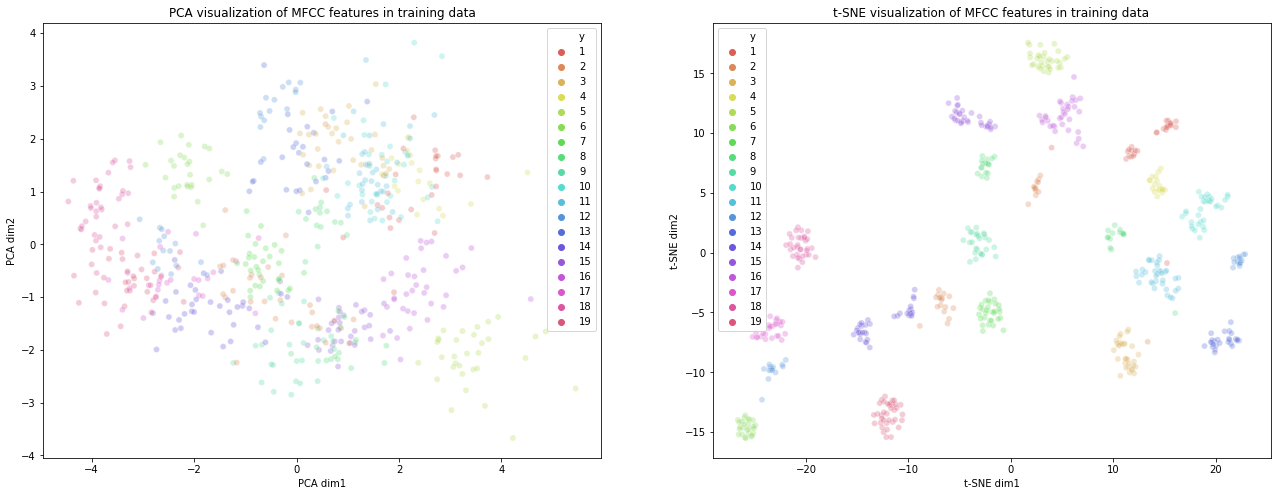

In [6]:
# The original data set is 13 dimension, for visualization, it should be reduced in two dimensions
# we prefer to feed the data in a DataFrame and then use the seaborn library to show the data for 2D visualization

feat_cols = [ str(i) for i in range(MFCC_train.shape[1]) ] 
df = pd.DataFrame(MFCC_train,columns=feat_cols)
df['y'] = y_train

twoD= sklearn.decomposition.PCA(n_components= 2).fit_transform(MFCC_train) #2D reduce dimension using PCA
tsne = TSNE(n_components=2, verbose=1, perplexity=40, n_iter=500).fit_transform(MFCC_train);#2D reduce dimension using t-SNE

plt.figure(figsize=(22,8))
ax1 = plt.subplot(1, 2, 1)
ax1= sns.scatterplot(
    x=twoD[:,0], y=twoD[:,1],
    hue="y",
    palette=sns.color_palette("hls", 19),
    data=df,
    legend="full",
    alpha=0.3
)
ax1.set(xlabel="PCA dim1", ylabel = "PCA dim2")
ax1.set_title('PCA visualization of MFCC features in training data')

ax2 = plt.subplot(1, 2, 2)
ax2= sns.scatterplot(
    x=tsne[:,0], y=tsne[:,1],
    hue="y",
    palette=sns.color_palette("hls", 19),
    data=df,
    legend="full",
    alpha=0.3
)
ax2.set(xlabel="t-SNE dim1", ylabel = "t-SNE dim2")
ax2.set_title('t-SNE visualization of MFCC features in training data');

# 3D Visualization of training data (Only PCA)

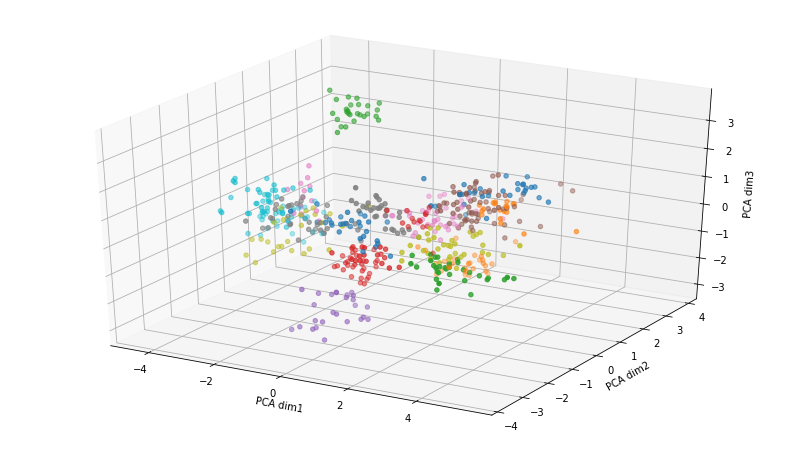

In [7]:
tD= sklearn.decomposition.PCA(n_components= 3).fit_transform(MFCC_train)

ax = plt.figure(figsize=(14,8)).gca(projection='3d')
ax.scatter(xs=tD[:,0], ys=tD[:,1], zs=tD[:,2], c=y_train, cmap='tab10')
ax.set_xlabel('PCA dim1')
ax.set_ylabel('PCA dim2')
ax.set_zlabel('PCA dim3')
plt.show()

# Classification Methods

## K nearest Neighborhood

As follows we apply the K nearest neighborhood for the MFCC data (and then for MFCC delta features), The hyperparameter in this classification are weights and k that can be changed in range of [1,40]. By considering the training and testing error, the best value for hyperparameter would be chosen.
(We prefered to use the GridSearch hyerperarameter search for knn).
Moreover, we use a 10 folded validation to ensure consistent distribution of classes in the training and testing phase and to also ensure that our model does not overfit for a particular split.

In [18]:
def KNN(xtrn, xtst, ytrn, ytst):
    '''
    In this function the best K-Nearest-Neighborhood is applied using GridSearch. The outpout is training and test
    accuracy and the Confusion matrix.
    It also prints the F-score.
    '''
    param_KNN={'n_neighbors':[1, 5, 10, 13, 15, 20, 25, 30, 40], 'weights':['uniform', 'distance']} 
    KNN= sklearn.neighbors.KNeighborsClassifier()
    GridSearch= sklearn.model_selection.GridSearchCV(KNN,param_KNN, verbose=1, cv=10).fit(xtrn, ytrn); 
    KNN_Score= GridSearch.best_score_*100
    print("The best score is: %.2f" %KNN_Score)
    print("The best patameters is:", GridSearch.best_params_)

    # Training and testing Scores
    GStrain=GridSearch.best_estimator_.score(xtrn, ytrn)*100
    GStest= GridSearch.best_estimator_.score(xtst, ytst)*100
    print('Randomized search:')
    print('%.1f%% train accuracy' %GStrain)
    print('%.1f%% test accuracy' %GStest)
    
    #F1 Score
    KNN_F1_metric= sklearn.metrics.f1_score(ytst, GridSearch.best_estimator_.predict(xtst), average='macro')
    print('KNN_F1_metric:', KNN_F1_metric)

    #Confusion Matrix
    fig, ax = plt.subplots(figsize=(8,8))
    sklearn.metrics.plot_confusion_matrix(GridSearch.best_estimator_, xtst,ytst, ax=ax)
    plt.show()


### Training KNN on MFCC and MFCC_ delta features

Fitting 10 folds for each of 18 candidates, totalling 180 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 180 out of 180 | elapsed:    1.7s finished


The best score is: 99.12
The best patameters is: {'n_neighbors': 1, 'weights': 'uniform'}
Randomized search:
100.0% train accuracy
99.7% test accuracy
KNN_F1_metric: 0.997353534685236


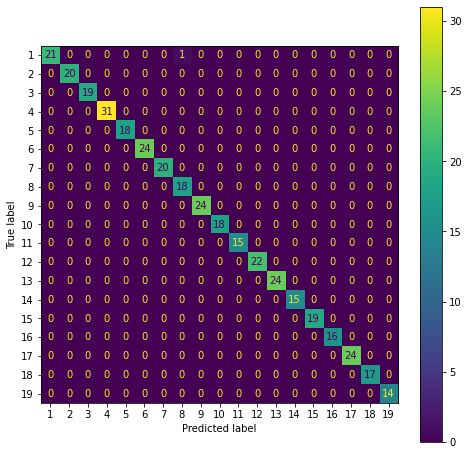

In [25]:
KNN(MFCC_train, MFCC_test,y_train , y_test)

Fitting 10 folds for each of 18 candidates, totalling 180 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 180 out of 180 | elapsed:    2.4s finished


The best score is: 96.32
The best patameters is: {'n_neighbors': 5, 'weights': 'distance'}
Randomized search:
100.0% train accuracy
97.1% test accuracy
KNN_F1_metric: 0.9682447382797639


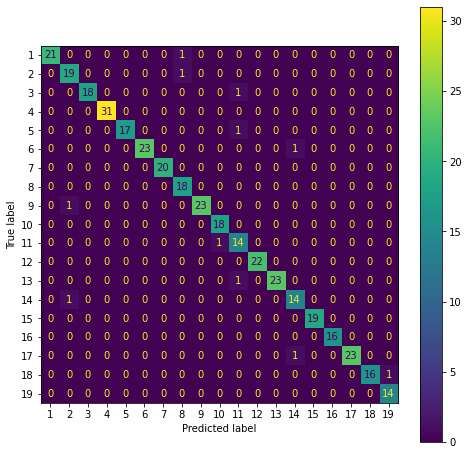

In [24]:
KNN(X_train, X_test, y_train , y_test)

In [27]:
# In this cell KNN is applied to the reduced dimension of X_train into different dimensions to see which one has
#the best accuracy
score1=[]
score2=[]
for i in range(1,26):
    PCA= sklearn.decomposition.PCA(n_components= i).fit(X_train)
    PCA_train= PCA.transform(X_train)
    PCA_test= PCA.transform(X_test)
    KNN1= sklearn.neighbors.KNeighborsClassifier(n_neighbors= 1, weights = 'uniform') #choose the best hyperparameters from previous part
    KNN2= KNN1= sklearn.neighbors.KNeighborsClassifier(n_neighbors= 5, weights = 'distance')
    KNN1.fit(PCA_train, y_train)
    KNN2.fit(PCA_train, y_train)
    score1.append(KNN1.score(PCA_test, y_test))
    score2.append(KNN2.score(PCA_test, y_test))
print("Best Dimension is", score1.index(max(score1)), 'tthe max accuracy is', max(score1)*100)
print("Best Dimension is", score1.index(max(score2)), 'tthe max accuracy is', max(score2)*100)

Best Dimension is 23 tthe max accuracy is 97.10526315789474
Best Dimension is 23 tthe max accuracy is 97.10526315789474


So the best Component in term of accuracy is 23 and there is no differnt that which two group hyperparameters are used.

## Support Vector Machine
In this Classification, two methods of OnevsRest and crammer_singer are applied for multiclass classification. The hyperparameter is C which is changed from log1= 0 to log100=2. The search for the best hyperparameter is randomized.

In [28]:
np.random.seed(0)

def SVM(xtrn, xtst, ytrn, ytst, **kwargs):
    '''
    In this function the best Linear SVC is found and applied on the data
    using RandomizedSearch. The outpout is training and test accuracy and the Confusion matrix.
    It also prints the F-score.
    '''
    SVC= sklearn.svm.LinearSVC(**kwargs)
    param_SVM= {'C':scipy.stats.reciprocal(1, 100)}
    SVM_search= sklearn.model_selection.RandomizedSearchCV(SVC, param_SVM,
                                                               random_state=0, verbose=1, n_iter=20, cv=10)
    SVM_search.fit(xtrn, ytrn);

    SVC_Score= SVM_search.best_score_*100
    print("The best score is: %.2f" %SVC_Score)
    print("The best patameters is:", SVM_search.best_params_)

    # Training and testing Scores
    SVCtrain=SVM_search.best_estimator_.score(xtrn, ytrn)*100
    SVCtest= SVM_search.best_estimator_.score(xtst, ytst)*100
    print('Randomized search:')
    print('%.1f%% train accuracy' %SVCtrain)
    print('%.1f%% test accuracy' %SVCtest)
    
    #F1 Score
    SVM_F1_metric= sklearn.metrics.f1_score(ytst, SVM_search.best_estimator_.predict(xtst), average='macro')
    print('SVM_F1_metric:', SVM_F1_metric)
    
    #Confusion Matrix
    fig, ax = plt.subplots(figsize=(8,8))
    sklearn.metrics.plot_confusion_matrix(SVM_search.best_estimator_, xtst,ytst, ax=ax)
    plt.show()

### Training KNN on MFCC and MFCC_ delta features

Fitting 10 folds for each of 20 candidates, totalling 200 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:   27.0s finished


The best score is: 99.12
The best patameters is: {'C': 12.520653814999461}
Randomized search:
100.0% train accuracy
97.9% test accuracy
SVM_F1_metric: 0.9790766477612541


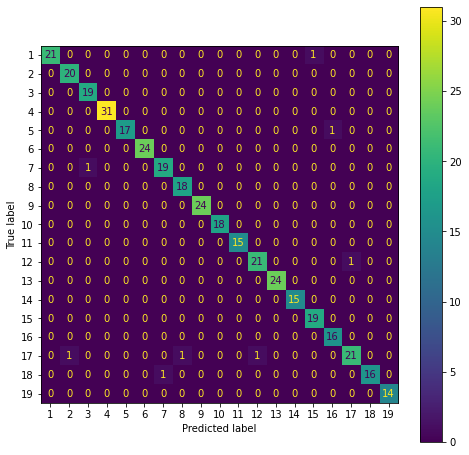

In [29]:
SVM(MFCC_train, MFCC_test,y_train , y_test, multi_class='crammer_singer')

Fitting 10 folds for each of 20 candidates, totalling 200 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:   14.0s finished


The best score is: 98.07
The best patameters is: {'C': 5.846326121643412}
Randomized search:
99.6% train accuracy
97.6% test accuracy
SVM_F1_metric: 0.9743080810802953


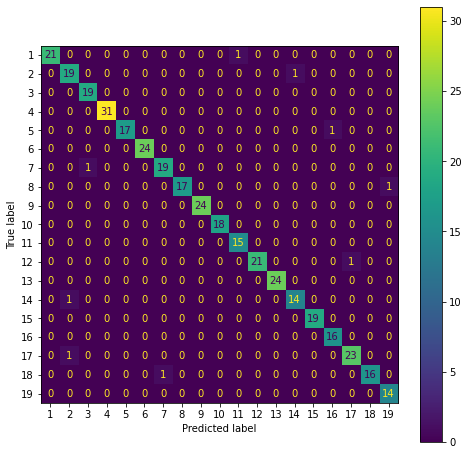

In [31]:
SVM(MFCC_train, MFCC_test,y_train , y_test, multi_class='ovr')

OvR seems better estimator, as it is faster and its testing accuracy is not much less than 'crammer_singer' so choose this one.
Rely on Previous part and choose 23 dimensions

Fitting 10 folds for each of 20 candidates, totalling 200 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:   28.1s finished


The best score is: 93.68
The best patameters is: {'C': 1.0975815419380157}
Randomized search:
98.8% train accuracy
95.3% test accuracy
SVM_F1_metric: 0.9502025677954826


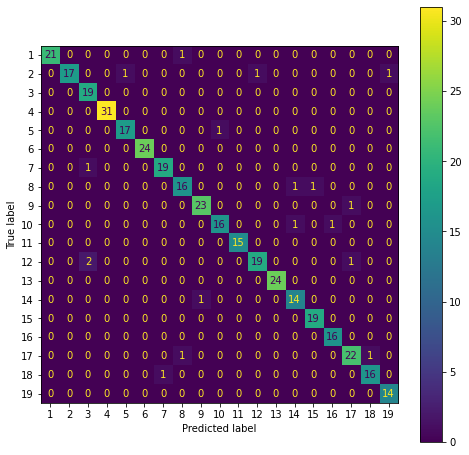

In [32]:
PCA= sklearn.decomposition.PCA(n_components= 23).fit(X_train)
PCA_train= PCA.transform(X_train)
PCA_test= PCA.transform(X_test)
SVM(PCA_train, PCA_test,y_train , y_test, multi_class='ovr')